In [1]:
#Import Modules

#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

import pandas as pd

#advectionGP
from advectionGP.models import AdjointAdvectionDiffusionReactionModel as Model #Model module builds basic parts of the PDE problem, combines other classes into full model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model
from advectionGP.wind import WindFixU #Wind model

#Plotting tools
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter


# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(6,8,3) # lower time
xloc=np.linspace(6,8,5) # x locations
yloc=np.linspace(6,8,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+0.1 # upper time

sensors = FixedSensorModel(X,0.1) # establish sensor model arguments are sensor locations and spatial averaging

# generate sensor locations for test data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(6,9,6) # lower time
xloc=np.linspace(6.5,7.5,6) # x locations
yloc=np.linspace(6.5,7.5,6) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
Xtest= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
Xtest[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] 
Xtest[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1]
Xtest[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2]
Xtest[:,1] = Xtest[:,0]+1

sensorsTest = FixedSensorModel(Xtest,1) # establish sensor model

In [2]:
# Run forward model to generate concentration
#u = [0.05,0.] #Advection


k_0 = 0.02 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=300 # number of features used to approximate ground truth GP
boundary = ([5,5,5],[10,10,10])# corners of the grid - in units of space
k = EQ(0.5, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [100,50,50] # grid size for time, x and y
wind=np.cos(np.linspace(0,6*np.pi,res[1]))*0.05
u=[]
u.append(0*np.ones(res)*wind) #x direction wind
u.append(0*np.ones(res)*0.0) # y direction wind
windmodel=WindFixU(u) # establish fixed wind model
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
source=(m.computeSourceFromPhi(z))+5# Compute source
#source[source<0]=0

#source = np.zeros(m.resolution)
##source[0,int(Nx/2)-1,int(Ny/2)-1] = 10.0
#source[:,15:25,15:25] = 5
#source[:,2:7,2:7] = 25
#source[:,7:12,15:20] = 25
#source[:,18:28,10:20] = 25

concTrain=m.computeConcentration(source) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations
concTrainNN=m.computeConcentration(source,enforce_nonnegative=True) # Compute concentration - runs advection diffusion forward model
yTrainNN= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

m.sensormodel=sensorsTest
yTest= m.computeObservations()

print(np.min(concTrain))
print(np.min(yTest))

/home/mike/Documents/Research/advectionGP/advectionGP/models.py:68: RuntimeWarning: divide by zero encountered in double_scalars
  if (dx>=2*self.k_0/np.min(self.u)): print("WARNING: spatial grid size does not meet the finite difference advection diffusion stability criteria")


0.0
5.16023314001954


In [3]:
N_feat = 300 #Number of features used to infer the source
k = EQ(0.5, 2.0) 
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0,R=R) #Initiate new model for inference
#%timeit -n1 -r1 regress = mInfer.computeModelRegressors() # Compute regressor matrix

In [4]:
from time import time

In [5]:
"""
Computes the regressor matrix X, using getHs from the sensor model and getPhi from the kernel.
X here is used to infer the distribution of z (and hence the source).
X is [features x observations]
"""
dt,dx,dy,dx2,dy2,Nt,Nx,Ny = mInfer.getGridStepSize()
X = np.zeros([mInfer.N_feat,len(mInfer.sensormodel.obsLocs)])

adjs = []
st = time()
for j,H in enumerate(mInfer.sensormodel.getHs(mInfer)):
    pass
print("getHs (all)           %6.1fms" % (1e3*(time()-st)))

st = time()
mInfer.computeAdjoint(H)
print("computeAdjoint (once) %6.1fms" % (1e3*(time()-st)))


st = time()
#O(GN)
for j,H in enumerate(mInfer.sensormodel.getHs(mInfer)):
    adjs.append(mInfer.computeAdjoint(H))
print("getHs & comp.Adjoints %6.1fms" % (1e3*(time()-st)))

st = time()
for i,phi in enumerate(mInfer.kernel.getPhi(mInfer.coords)):
    pass
print("getPhis               %6.1fms" % (1e3*(time()-st)))

st = time()
#O(GNF)
for i,phi in enumerate(mInfer.kernel.getPhi(mInfer.coords)):
    for j,adj in enumerate(adjs):
        X[i,j] = np.sum((phi*adj))*dt*dx*dy
        
print("getPhis and products  %6.1fms" % (1e3*(time()-st)))
#phi * v, --> scale

getHs (all)             56.2ms
computeAdjoint (once)   46.3ms
getHs & comp.Adjoints 1779.2ms
getPhis               1687.9ms
getPhis and products  11805.2ms


In [31]:
def getPhiValues(kernel,particles):
    c=1/(kernel.l2)
    norm = 1./np.sqrt(kernel.N_feat)
    return norm*np.sqrt(2*kernel.sigma2)*np.cos(c*np.einsum('ij,lkj',kernel.W,particles)+kernel.b[:,None,None])

st = time()
Nsamps = 25
scale = Nsamps / dt

particles = []
N_obs = len(mInfer.sensormodel.obsLocs)
for obsi in range(N_obs):
    locA = mInfer.sensormodel.obsLocs[obsi,[0,2,3]]
    locB = mInfer.sensormodel.obsLocs[obsi,[1,2,3]]
    newparticles = np.repeat(locA[None,:],Nsamps,0)
    newparticles[:,0]+=np.random.rand(len(newparticles))*(locB[0]-locA[0])
    particles.append(newparticles)
particles = np.array(particles)

newX = np.zeros([N_feat,N_obs])
for nit in range(500):#+int(locB[0]/dt)):
    particles[:,:,1:]+=np.random.randn(particles.shape[0],particles.shape[1],2)*np.sqrt(2*dt*mInfer.k_0) #plus wind
    particles[:,:,0]-=dt
    keep = particles[:,0,0]>mInfer.boundary[0][0] #could extend to be within grid space
    newX[:,keep] += np.sum(getPhiValues(mInfer.kernel,particles),axis=(1))[:,keep]
    if np.sum(keep)==0: 
        break
newX = np.array(newX)/scale
print("run new particle method  %6.1fms" % (1e3*(time()-st)))

run new particle method  1049.8ms


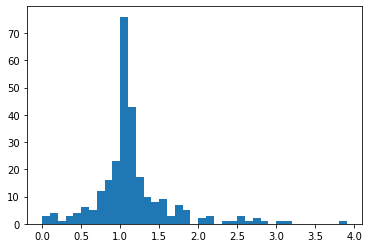

In [22]:
#assumed fixed:
#griderrorscale = np.sum(next(mInfer.sensormodel.getHs(mInfer)))*(dt*dx*dy)
#print(griderrorscale)

plt.hist(newX[:,0]/(X[:,0]),np.arange(0,4,0.1)); 

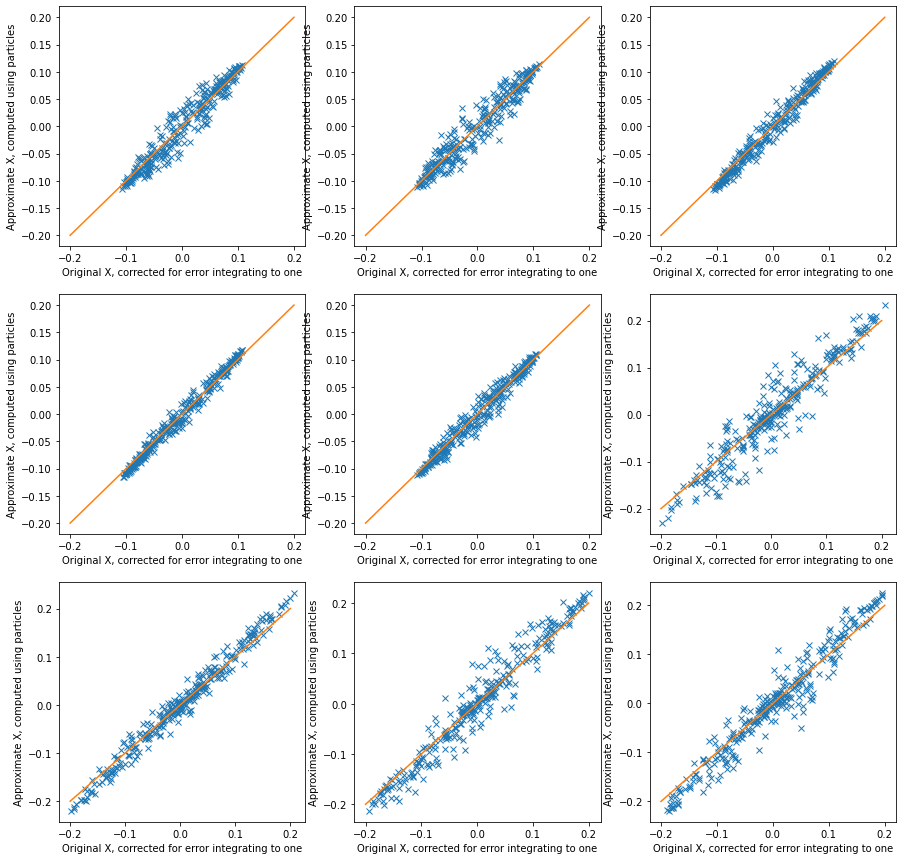

In [23]:
plt.figure(figsize=[15,15])
for plti in range(9):
    plt.subplot(3,3,plti+1)
    plt.plot(X[:,plti],newX[:,plti],'x')
    plt.xlabel('Original X, corrected for error integrating to one')
    plt.ylabel('Approximate X, computed using particles')
    plt.plot([-0.2,0.2],[-0.2,0.2])

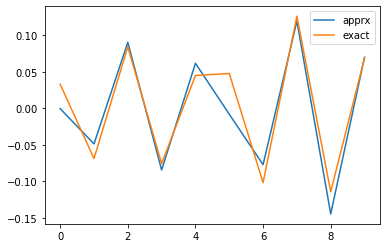

In [24]:
plt.plot(newX.T[:10,5],label='apprx')
plt.plot(X.T[:10,5],label='exact')
plt.legend()

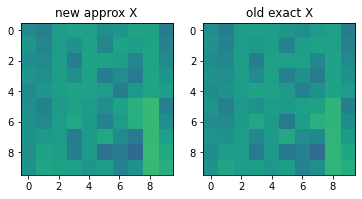

In [25]:
plt.subplot(1,2,1)
plt.title('new approx X')
plt.imshow(newX.T[:10,:10],clim=[-.6,.6])
plt.subplot(1,2,2)
plt.title('old exact X')
plt.imshow(X.T[:10,:10],clim=[-.6,.6])

In [32]:
#skip for now...
#meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
#sampsZ = np.random.multivariate_normal(meanZ,covZ,15)
#sampsSource = []
#for s in sampsZ:
#    sampsSource.append(mInfer.computeSourceFromPhi(s))
#sampsSource = np.array(sampsSource)
#uncertainty = np.std(sampsSource,0)

In [33]:
#plt.contour(uncertainty[5,:,:])#,levels=np.arange(0,0.501,0.125)*np.mean(source))
#plt.colorbar()

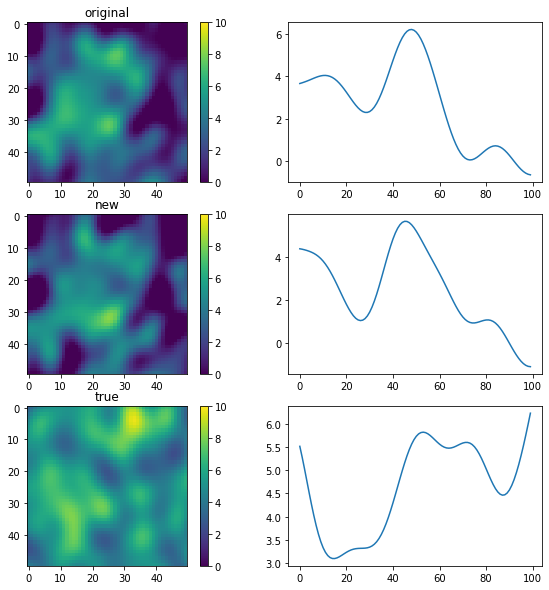

In [34]:
plt.figure(figsize=[10,10])
for plti,(title,useX) in enumerate(zip(['original','new','true'],[X,newX,None])):
    mInfer.X = useX
    plt.subplot(3,2,(plti*2)+1)
    plt.title(title)
    #regress = m.computeModelRegressors() # Compute regressor matrix
    if title!='true':
        meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance
        sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio
    else:
        sourceInfer = source
    plt.imshow(sourceInfer[5,:,:],clim=[0,10])
    plt.colorbar()
    #plt.contour(uncertainty[5,:,:])
    plt.subplot(3,2,(plti*2)+2)
    plt.plot(sourceInfer[:,25,25])
    
    #plt.ylim([0,3])